<a href="https://colab.research.google.com/github/cavannus/ttow-ML/blob/main/wayang_mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Unzip the dataset. The dataset are already split into test, train, and val.

In [ ]:
import os
import zipfile

# local_zip = '/content/wayang-reduced-further.zip'
# local_zip = '/content/wayang-reduced.zip'
local_zip = '/content/wayang.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
base_dir = '/content/images/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

In [ ]:
IMG_SIZE = (175, 225)
IMG_SHAPE = IMG_SIZE + (3,)

In [ ]:
import tensorflow as tf

In [ ]:
train_batch = 24
train_epoch = 45
val_batch = 10
val_epoch = 12

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale = 1.0/255,
                                   horizontal_flip = True,
                                   width_shift_range = 0.5,
                                   height_shift_range = 0.5,
                                   fill_mode = 'nearest',
                                   shear_range = 0.5,
                                   rotation_range=60,
                                   zoom_range=0.4,
                                   )
test_datagen  = ImageDataGenerator(rescale = 1.0/255,)

# --------------------
# Flow training images in batches of 15 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=train_batch,
                                                    class_mode='categorical',
                                                    target_size=(175, 225))     
# --------------------
# Flow validation images in batches of 15 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=val_batch,
                                                         class_mode='categorical',
                                                         target_size=(175, 225))


Found 1080 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


This part defines the model used for transfer learning, which is MobileNetV2.

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.summary()

Fine tuning on MobileNet by unfreezing the first 50 layer of the model

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:125]:
  layer.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=(175, 225, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(16)(x)
x = tf.keras.layers.Dense(32)(x)
x = tf.keras.layers.Dense(64)(x)
x = tf.keras.layers.Dense(32)(x)
x = tf.keras.layers.Dense(16)(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 1e-5
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 175, 225, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 6, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_13  (None, 1280)              0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 16)                20496     
_________________________________________________________________
dense_26 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_27 (Dense)             (None, 64)                211

In [ ]:
class Acc_Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if logs['accuracy'] > 0.95:
      print('\nAccuracy is more than 95%')
      self.model.stop_training = True
    elif logs['val_accuracy'] > 0.90:
      print('\nVal-Accuracy is more than 95%')
      self.model.stop_training = True

earlyStop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=1e-5, patience=5)

callbacks = [Acc_Callback(),
             earlyStop,
             ]

In [ ]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=train_batch,
                    epochs=train_epoch,
                    validation_steps=val_epoch,
                    verbose=2,
                    callbacks=callbacks)

Epoch 1/45
24/24 - 30s - loss: 1.9588 - accuracy: 0.2326 - val_loss: 1.3019 - val_accuracy: 0.5333
Epoch 2/45
24/24 - 26s - loss: 1.5496 - accuracy: 0.3003 - val_loss: 1.1796 - val_accuracy: 0.6333
Epoch 3/45
24/24 - 26s - loss: 1.4206 - accuracy: 0.3351 - val_loss: 1.1098 - val_accuracy: 0.6333
Epoch 4/45
24/24 - 26s - loss: 1.3640 - accuracy: 0.3559 - val_loss: 1.0650 - val_accuracy: 0.6917
Epoch 5/45
24/24 - 26s - loss: 1.2390 - accuracy: 0.4601 - val_loss: 1.0086 - val_accuracy: 0.7167
Epoch 6/45
24/24 - 26s - loss: 1.2386 - accuracy: 0.4323 - val_loss: 0.9474 - val_accuracy: 0.6833
Epoch 7/45
24/24 - 26s - loss: 1.2037 - accuracy: 0.4410 - val_loss: 0.9094 - val_accuracy: 0.7000
Epoch 8/45
24/24 - 26s - loss: 1.1169 - accuracy: 0.5434 - val_loss: 0.8568 - val_accuracy: 0.7250
Epoch 9/45
24/24 - 26s - loss: 1.0942 - accuracy: 0.5208 - val_loss: 0.8023 - val_accuracy: 0.7417
Epoch 10/45
24/24 - 26s - loss: 1.0925 - accuracy: 0.5052 - val_loss: 0.7534 - val_accuracy: 0.7417
Epoch 11/

Text(0.5, 1.0, 'Training and validation loss')

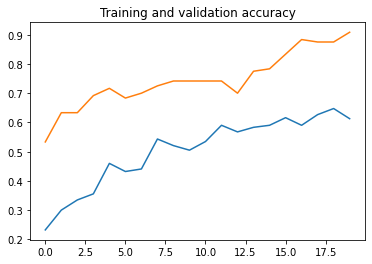

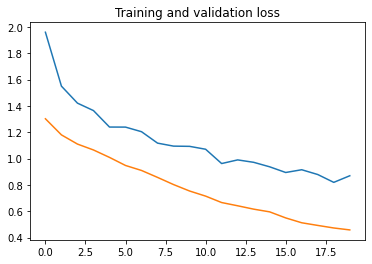

In [ ]:
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [ ]:
train_generator.class_indices

{'bagong': 0, 'gareng': 1, 'petruk': 2, 'semar': 3}

In [ ]:
modelBaseName = 'wayang-mobilenet-v2'
modelTFLite = modelBaseName + '.tflite'
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open(modelTFLite, 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmp9emcfh_i/assets


INFO:tensorflow:Assets written to: /tmp/tmp9emcfh_i/assets


In [ ]:
modelH5 = modelBaseName + '.h5'

model.save(modelH5)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
from google.colab import files

files.download(modelTFLite)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  
  path='/content/' + fn
  img=image.load_img(path, target_size=(175, 225))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes)

KeyboardInterrupt: ignored